# Getting Started with `AD`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import AD

## Declaring Variables and Performing Elementary Operations
### Scalar Variables
We may define a scalar variable as follows.

In [2]:
x = AD.Forward(np.pi)

Note that we when a value for the derivative is not specified, a default value of `1.0` is assigned automatically.

In [3]:
x

Value:
3.141592653589793
Derivative:
1.0

However, we also allow the user to specify a value for the derivative.

In [4]:
y = AD.Forward(1.0, 3.0)
y

Value:
1.0
Derivative:
3.0

In addition, we may use scalar variables to define custom scalar functions composed of standard elementary operations.

In [5]:
def f(x):
    return x**2 + AD.cos(x) + 0.5*AD.exp(-x**2)

f(x)

Value:
8.86963026268246
Derivative:
6.283022813997788

<div class="alert alert-info"> 
    Since <code>x</code> is a forward mode variable, we must use the implementations of elementary functions defined in the <code>AD</code> module instead of the standard Numpy methods.
</div>

### Scalar Variables Using Arrays
Suppose we wish to define a scalar variable containing an array as the function value to visualize both the function and derivative values (e.g. plot $\sin x$). `Forward` is versatile enough to handle this directly!

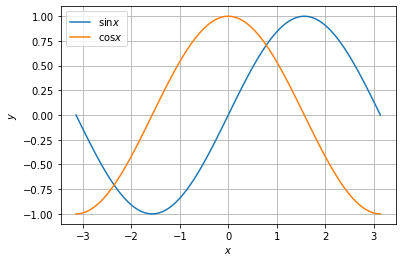

In [6]:
# Instance of the `Forward` class with an array as the function value
x = AD.Forward(np.linspace(-np.pi, np.pi, 100))

# Function to visualize
f1 = AD.sin(x)

# Plot function and derivative
plt.figure()
plt.plot(x.val, f1.val, label="$\sin x$")
plt.plot(x.val, f1.der, label="$\cos x$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.grid()
plt.show()

### Scalar Variables of Vector Functions
Defining a `Forward` variable for a vector function can be accomplished by making use of the attributes defined in the `Forward` class. 

In [7]:
# Custom vector-valued function in R^2
def f(x, y, z):
    
    # Use the arguments of the callable function to define instances of the Forward class.
    X = AD.Forward(x, [1, 0, 0])
    Y = AD.Forward(y, [0, 1, 0])
    Z = AD.Forward(z, [0, 0, 1])
    
    # Operate on the instances of the Forward class to obtain the components of the vector function.
    # NOTE: These are also instances of the Forward class.
    Fx = AD.sin(X)
    Fy = 4*Y + Z**3
    
    # Manually build the value and derivative arguments that will be used to return a new instance of
    # Forward from the components.
    val = [Fx.val, Fy.val]
    jac = [Fx.der, Fy.der]
    
    return AD.Forward(val, jac)

In [8]:
f(np.pi/2, 3, -2)

Value:
[1. 4.]
Jacobian:
[[ 0.  0.  0.]
 [ 0.  4. 12.]]

<div class="alert alert-danger">
<b>The usage for vector functions works but is less friendly than the usage for scalar functions. This may need to be improved before the final submission.</b>
</div>

## Application: Newton's Method in Higher Dimensions

Newton's method is an iterative technique for finding the zeros of nonlinear functions. For scalar functions of a single variable (e.g. $f(x)$), the iterations may be calculated as follows.
\begin{equation}
    x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)}
\end{equation}
Here, $x_{k+1}$ is the next iteration, $x_k$ is the previous iteration, and $f(x)$ is the function of interest. 

The same technique can be generalized to encompass multivariate vector-valued functions. Suppose $\mathbf{f}(\mathbf{x}) \in \mathbb{R}^n$ is the differentiable function of interest. Then, the system of equations we wish to solve is $\mathbf{f}(\mathbf{x}) = \mathbf{0}$. Newton's method calculates the solution iteratively as follows.
\begin{equation}
    \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} + \delta\mathbf{x}^{(k)}
\end{equation}
Here, the second term on the right-hand side is defined as
\begin{equation}
    \delta\mathbf{x}^{(k)} = -\mathbf{J}\left(\mathbf{x}^{(k)}\right)^{-1}\mathbf{f}\left(\mathbf{x}^{(k)}\right),
\end{equation}
where $\mathbf{J}\left(\mathbf{x}^{(k)}\right)$ is the Jacobian evaluated at $\mathbf{x}^{(k)}$. In general, it is computationally expensive to explicitly calculate the inverse of a matrix, so instead, we obtain $\delta\mathbf{x}^{(k)}$ by solving the system
\begin{equation}
    \mathbf{J}\left(\mathbf{x}^{(k)}\right)\delta\mathbf{x}^{(k)} = -\mathbf{f}\left(\mathbf{x}^{(k)}\right)
\end{equation}
via Gaussian elimination.

In [9]:
def newton(f, x0, tol=1e-8, max_iter=100):
    """Newton's method for multivariate vector functions
    
    Parameters:
    ===========
    f (callable): vector function of interest
    x0 (array_like): initial guess in the form [x, y, z]
    tol (float): tolerance value; by default set to 1e-8
    max_iter (int): maximum number of iterations to execute
    
    Returns:
    ========
    xn (array): solution, if the algorithm converges
    
    """
    
    # Initial guess
    xn = x0
    
    for n in range(max_iter):
        
        # Evaluate f
        fn = f(*xn)
            
        # Calculate difference vector
        df = np.linalg.solve(fn.der, -fn.val)
        
        if abs(df).any() < tol:
            print(f"Found a solution after {n} iterations.")
            return np.around(xn, decimals=3)
        
        if np.linalg.det(fn.der) == 0:
            raise ValueError("Jacobian not invertible. No solution.")
        
        # Update the guess
        xn = xn + df
    
    print("Exceeded maximum number of iterations.")
    return None

In [10]:
# Example: Adapted from section 3.1 of "The Mathematics of Nonlinear Programming" by Peressini, Sullivan and Uhl
def f(x,y,z):
    X = AD.Forward(x, [1, 0, 0])
    Y = AD.Forward(y, [0, 1, 0])
    Z = AD.Forward(z, [0, 0, 1])
    
    Fx = X**2 + Y**2 + Z**2 - 3
    Fy = X**2 + Y**2 - Z - 1
    Fz = X + Y + Z - 3
    
    val = np.asarray([Fx.val, Fy.val, Fz.val])
    jac = np.asarray([Fx.der, Fy.der, Fz.der])
    
    return AD.Forward(val, jac)

In [11]:
newton(f, [1, 0, 1])

Found a solution after 27 iterations.


array([1., 1., 1.])

<div class="alert alert-info">
    <b>Something to think about:</b> It might be a good idea to add this as an additional feature in our module.
</div>